In [1]:
!git clone https://github.com/LeonardoMonte/CompEvolutiva.git
!pip install -q SwarmPackagepy

Cloning into 'CompEvolutiva'...
remote: Enumerating objects: 13059, done.
remote: Counting objects: 100% (13059/13059), done.
remote: Compressing objects: 100% (9437/9437), done.
remote: Total 13059 (delta 3553), reused 13058 (delta 3552), pack-reused 0
Receiving objects: 100% (13059/13059), 91.37 MiB | 27.80 MiB/s, done.
Resolving deltas: 100% (3553/3553), done.
Checking out files: 100% (12740/12740), done.


# Functions

In [2]:
import numpy as np
import random
import pandas as pd
import glob
import cv2
from sklearn.decomposition import PCA
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import time
from scipy.stats import friedmanchisquare
import matplotlib.pyplot as plt
from keras.models import model_from_json
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

def reshape3dto2d(arrayphotos):

    size = len(arrayphotos)
    for x in range (0 , size):
        arrayphotos[x] = np.reshape(arrayphotos[x], (arrayphotos[x].shape[0], (arrayphotos[x].shape[1]*arrayphotos[x].shape[2])))

    return arrayphotos

def loadfolderimgs(path):

    arrayphotos = []

    for img in glob.glob(path):
        n = cv2.imread(img)
        arrayphotos.append(n)

    return arrayphotos
  
def Turntogray(arrayphotos):

    size = len(arrayphotos)
    for x in range (0,size):
        arrayphotos[x] = cv2.cvtColor(arrayphotos[x], cv2.COLOR_BGR2GRAY)

    return arrayphotos
  
def resizephotos(arrayphotos, size1, size2):

    size = len(arrayphotos)
    for x in range (0,size):
        arrayphotos[x] = cv2.resize(arrayphotos[x], (size1,size2))

    return arrayphotos
  
def gethumoments(arrayphotos):

    for x in range(len(arrayphotos)):

        arrayphotos[x] = cv2.HuMoments(cv2.moments(arrayphotos[x]), True).flatten()

    return arrayphotos
  
def amostra_estrat(tam , df , classe):
    classes = df[classe].unique()
    qtde_por_classe = round(tam / len(classes))
    amostras_por_classe = []
    for c in classes:
        indices_c = df[classe] == c
        obs_c = df[indices_c]
        amostra_c = obs_c.sample(qtde_por_classe)
        amostras_por_classe.append(amostra_c)
    amostra_estratificada = pd.concat(amostras_por_classe)
    return amostra_estratificada
  
def binaryadaptive(arrayphotos,threshold,val1):

    for x in range(len(arrayphotos)):
        arrayphotos[x] = cv2.adaptiveThreshold(arrayphotos[x],threshold,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,val1,10)
        
    return arrayphotos

def invertbinaryphotos(arrayphotos):

    for x in range(len(arrayphotos)):
        arrayphotos[x] = cv2.bitwise_not(arrayphotos[x])

    return arrayphotos
  
def getHOGplusHU(arrayphotos):
    hog = cv2.HOGDescriptor()
    for x in range(len(arrayphotos)):
        aux = []


        h = hog.compute(arrayphotos[x]).flatten()

        for ho in h:
            aux.append(ho)

        hu = cv2.HuMoments(cv2.moments(arrayphotos[x]), True).flatten()

        for huu in hu:
            aux.append(huu)

        arrayphotos[x] = aux

    return arrayphotos
  
def PCAdataframe(pcanumber,dataframe):

    pca = PCA(n_components=pcanumber)
    dataframe = pca.fit_transform(dataframe)

    return dataframe
  
  
class LocalBinaryPatterns:
  
    def __init__(self, numPoints, radius):
      # store the number of points and radius
      self.numPoints = numPoints
      self.radius = radius

    def describe(self, image, eps=1e-7):
      # compute the Local Binary Pattern representation
      # of the image, and then use the LBP representation
      # to build the histogram of patterns
      lbp = feature.local_binary_pattern(image, self.numPoints,
        self.radius, method="uniform")
      (hist, _) = np.histogram(lbp.ravel(),
        bins=np.arange(0, self.numPoints + 3),
        range=(0, self.numPoints + 2))

      # normalize the histogram
      hist = hist.astype("float")
      hist /= (hist.sum() + eps)

      # return the histogram of Local Binary Patterns
      return hist
    
def getHOGplusLBP(arrayphotos):
    hog = cv2.HOGDescriptor()
    lbp = LocalBinaryPatterns(8,4)
    for x in range(len(arrayphotos)):
        aux = []
        
        h = hog.compute(arrayphotos[x]).flatten()
        for ho in h:
            aux.append(ho)
            
        pbl = lbp.describe(arrayphotos[x])        
        for a in pbl:
            aux.append(a)
        
        arrayphotos[x] = aux

    return arrayphotos    
    

def normalize(df1):
    x = df1.values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled = min_max_scaler.fit_transform(x)
    df_normalized = pd.DataFrame(scaled)
    return df_normalized
  
  
def creatpopuMSRA(sizepopu,sizecromo):
    
  limit = np.sqrt(6/float(sizecromo))
  chromossomos = [np.random.uniform(low = -limit,high = limit, size = sizecromo) for x in range(sizepopu)]
  return chromossomos
  
def creatpopu(sizepopu, sizecromo):

    chromossomos = []
    for x in range(sizepopu):
        aux = []
        for y in range(sizecromo):
            element = random.uniform(-1,1)
            aux.append(element)

        chromossomos.append(aux)

    return chromossomos
  
def creatpopuSTD(sizepopu, sizecromo):

    std = []
    for x in range(sizepopu):
        aux2 = []
        for y in range(sizecromo):
            element2 = random.uniform(-1,1)/6
            aux2.append(element2)          

        std.append(aux2)

    return np.array(std)


# MLP PART

model = Sequential()
model.add(Dense(6, input_dim = 50, activation="relu", name='dense1'))
model.add(Dense(1, activation="sigmoid", name='dense2'))    
model.compile( loss='binary_crossentropy', optimizer="adam", 
              metrics=['accuracy'])


######## FITNESS PART ######################

arrayfitnessGA = []
arrayfitnessDE = []
arrayfitnessEE = []
arrayfitnessEEC = []
arrayfitnessPE = []
arrayfitnessGADE = []
arrayfitnessPSO = []
arrayfitnessGSO = []
arrayfitnessGSA = []
arrayfitnessGWO = []
arrayfitnessGWOGSO = []
arrayfitnessGSAPSO = []

############################ FITNESS KFOLD ############################


def fitnessGA(chromossome, Xtrain,ytrain,Xval,yval):
  

  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))
  
  model.fit(Xtrain, ytrain, epochs=20, batch_size=256, verbose = False)
  retorno = model.evaluate(Xval,yval, verbose = False)
  
  if len(arrayfitnessGA) == 0:
    model_json = model.to_json()
    with open("modelGA.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelGA.h5")

  atual = retorno[1]

  if len(arrayfitnessGA) > 1:
    if atual > arrayfitnessGA[np.argmax(arrayfitnessGA)]:
      model_json = model.to_json()
      with open("modelGA.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelGA.h5")

  arrayfitnessGA.append(atual)
  
  return atual


def fitnessDE(chromossome,Xtrain,ytrain,Xval,yval):
    
  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1))) 
  
  model.fit(Xtrain, ytrain, epochs=20, batch_size=256, verbose = False)
  retorno = model.evaluate(Xval,yval, verbose = False)

  if len(arrayfitnessDE) == 0:
    model_json = model.to_json()
    with open("modelDE.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelDE.h5")

  atual = retorno[1]

  if len(arrayfitnessDE) > 1:
    if atual > arrayfitnessDE[np.argmax(arrayfitnessDE)]:
      model_json = model.to_json()
      with open("modelDE.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelDE.h5")

  arrayfitnessDE.append(atual)
    
  return atual

def fitnessEE(chromossome,Xtrain,ytrain,Xval,yval):
  
  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))  

  model.fit(Xtrain, ytrain, epochs=20, batch_size=256, verbose = False)
  retorno = model.evaluate(Xval,yval, verbose = False)

  if len(arrayfitnessEE) == 0:
    model_json = model.to_json()
    with open("modelEE.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelEE.h5")

  atual = retorno[1]

  if len(arrayfitnessEE) > 1:
    if atual > arrayfitnessEE[np.argmax(arrayfitnessEE)]:
      model_json = model.to_json()
      with open("modelEE.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelEE.h5")

  arrayfitnessEE.append(atual)
    
  return atual

def fitnessEEC(chromossome,Xtrain,ytrain,Xval,yval):
   
  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))
  
  model.fit(Xtrain, ytrain, epochs=20, batch_size=256, verbose = False)
  retorno = model.evaluate(Xval,yval, verbose = False)

  if len(arrayfitnessEEC) == 0:
    model_json = model.to_json()
    with open("modelEEC.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelEEC.h5")

  atual = retorno[1]

  if len(arrayfitnessEEC) > 1:
    if atual > arrayfitnessEEC[np.argmax(arrayfitnessEEC)]:
      model_json = model.to_json()
      with open("modelEEC.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelEEC.h5")

  arrayfitnessEEC.append(atual)

  return atual

def fitnessPE(chromossome,Xtrain,ytrain,Xval,yval):
  
  
  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))
  
  model.fit(Xtrain, ytrain, epochs=20, batch_size=256, verbose = False)
  retorno = model.evaluate(Xval,yval, verbose = False)

  if len(arrayfitnessPE) == 0:
    model_json = model.to_json()
    with open("modelPE.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelPE.h5")

  atual = retorno[1]

  if len(arrayfitnessPE) > 1:
    if atual > arrayfitnessPE[np.argmax(arrayfitnessPE)]:
      model_json = model.to_json()
      with open("modelPE.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelPE.h5")

  arrayfitnessPE.append(atual)
    
  return atual


def fitnessGADE(chromossome,Xtrain,ytrain,Xval,yval):
  
  
  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))
  

  model.fit(Xtrain, ytrain, epochs=20, batch_size=256, verbose = False)
  retorno = model.evaluate(Xval,yval, verbose = False)

  if len(arrayfitnessGADE) == 0:
    model_json = model.to_json()
    with open("modelGADE.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelGADE.h5")

  atual = retorno[1]

  if len(arrayfitnessGADE) > 1:
    if atual > arrayfitnessGADE[np.argmax(arrayfitnessGADE)]:
      model_json = model.to_json()
      with open("modelGADE.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelGADE.h5")

  arrayfitnessGADE.append(atual)
    
  return atual


def fitnessPSO(chromossome,Xtrain,ytrain,Xval,yval):
  
  
  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))
  
  model.fit(Xtrain, ytrain, epochs=20, batch_size=256, verbose = False)
  retorno = model.evaluate(Xval,yval, verbose = False)

  if len(arrayfitnessPSO) == 0:
    model_json = model.to_json()
    with open("modelPSO.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelPSO.h5")

  atual = retorno[1]

  if len(arrayfitnessPSO) > 1:
    if atual > arrayfitnessPSO[np.argmax(arrayfitnessPSO)]:
      model_json = model.to_json()
      with open("modelPSO.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelPSO.h5")

  arrayfitnessPSO.append(atual)

  return atual

def fitnessGSO(chromossome,Xtrain,ytrain,Xval,yval):
    
  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))
  model.fit(Xtrain, ytrain, epochs=20, batch_size=256, verbose = False)
  retorno = model.evaluate(Xval,yval, verbose = False)

  if len(arrayfitnessGSO) == 0:
    model_json = model.to_json()
    with open("modelGSO.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelGSO.h5")

  atual = retorno[1]

  if len(arrayfitnessGSO) > 1:
    if atual > arrayfitnessGSO[np.argmax(arrayfitnessGSO)]:
      model_json = model.to_json()
      with open("modelGSO.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelGSO.h5")

  arrayfitnessGSO.append(atual)
  
  return atual


def fitnessGSA(chromossome,Xtrain,ytrain,Xval,yval):
    
  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))
  model.fit(Xtrain, ytrain, epochs=20, batch_size=256, verbose = False)
  retorno = model.evaluate(Xval,yval, verbose = False)

  if len(arrayfitnessGSA) == 0:
    model_json = model.to_json()
    with open("modelGSA.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelGSA.h5")

  atual = retorno[1]

  if len(arrayfitnessGSA) > 1:
    if atual > arrayfitnessGSA[np.argmax(arrayfitnessGSA)]:
      model_json = model.to_json()
      with open("modelGSA.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelGSA.h5")

  arrayfitnessGSA.append(atual)
  
  return atual


def fitnessGWO(chromossome,Xtrain,ytrain,Xval,yval):
    
  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))
  model.fit(Xtrain, ytrain, epochs=20, batch_size=256, verbose = False)
  retorno = model.evaluate(Xval,yval, verbose = False)

  if len(arrayfitnessGWO) == 0:
    model_json = model.to_json()
    with open("modelGWO.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelGWO.h5")

  atual = retorno[1]

  if len(arrayfitnessGWO) > 1:
    if atual > arrayfitnessGWO[np.argmax(arrayfitnessGWO)]:
      model_json = model.to_json()
      with open("modelGWO.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelGWO.h5")

  arrayfitnessGWO.append(atual)
  
  return atual

def fitnessGWOGSO(chromossome,Xtrain,ytrain,Xval,yval):
    
  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))
  model.fit(Xtrain, ytrain, epochs=20, batch_size=256, verbose = False)
  retorno = model.evaluate(Xval,yval, verbose = False)

  if len(arrayfitnessGWOGSO) == 0:
    model_json = model.to_json()
    with open("modelGWOGSO.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelGWOGSO.h5")

  atual = retorno[1]

  if len(arrayfitnessGWOGSO) > 1:
    if atual > arrayfitnessGWOGSO[np.argmax(arrayfitnessGWOGSO)]:
      model_json = model.to_json()
      with open("modelGWOGSO.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelGWOGSO.h5")

  arrayfitnessGWOGSO.append(atual)
  
  return atual

def fitnessGSAPSO(chromossome,Xtrain,ytrain,Xval,yval):
    
  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))
  model.fit(Xtrain, ytrain, epochs=20, batch_size=256, verbose = False)
  retorno = model.evaluate(Xval,yval, verbose = False)

  if len(arrayfitnessGSAPSO) == 0:
    model_json = model.to_json()
    with open("modelGSAPSO.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelGSAPSO.h5")

  atual = retorno[1]

  if len(arrayfitnessGSAPSO) > 1:
    if atual > arrayfitnessGSAPSO[np.argmax(arrayfitnessGSAPSO)]:
      model_json = model.to_json()
      with open("modelGSAPSO.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelGSAPSO.h5")

  arrayfitnessGSAPSO.append(atual)
  
  return atual


############# LOAD MODEL ###############################33


def loadmodelGA():
  
  json_file = open('modelGA.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  loaded_model.load_weights("modelGA.h5")
  loaded_model.compile( loss='binary_crossentropy', optimizer="adam", 
              metrics=['accuracy'])
  
  return loaded_model

def loadmodelDE():
  
  json_file = open('modelDE.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  loaded_model.load_weights("modelDE.h5")
  loaded_model.compile( loss='binary_crossentropy', optimizer="adam", 
              metrics=['accuracy'])
  
  return loaded_model

def loadmodelEE():
  
  json_file = open('modelEE.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  loaded_model.load_weights("modelEE.h5")
  loaded_model.compile( loss='binary_crossentropy', optimizer="adam", 
              metrics=['accuracy'])
  
  return loaded_model

def loadmodelEEC():
  
  json_file = open('modelEEC.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  loaded_model.load_weights("modelEEC.h5")
  loaded_model.compile( loss='binary_crossentropy', optimizer="adam", 
              metrics=['accuracy'])
  
  return loaded_model

def loadmodelPE():
  
  json_file = open('modelPE.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  loaded_model.load_weights("modelPE.h5")
  loaded_model.compile( loss='binary_crossentropy', optimizer="adam", 
              metrics=['accuracy'])
  
  return loaded_model


def loadmodelGADE():
  
  json_file = open('modelGADE.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  loaded_model.load_weights("modelGADE.h5")
  loaded_model.compile( loss='binary_crossentropy', optimizer="adam", 
              metrics=['accuracy'])
  
  return loaded_model

def loadmodelPSO():
  
  json_file = open('modelPSO.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  loaded_model.load_weights("modelPSO.h5")
  loaded_model.compile( loss='binary_crossentropy', optimizer="adam", 
              metrics=['accuracy'])
  
  return loaded_model

def loadmodelGSO():
  
  json_file = open('modelGSO.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  loaded_model.load_weights("modelGSO.h5")
  loaded_model.compile( loss='binary_crossentropy', optimizer="adam", 
              metrics=['accuracy'])
  
  return loaded_model

def loadmodelGSA():
  
  json_file = open('modelGSA.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  loaded_model.load_weights("modelGSA.h5")
  loaded_model.compile( loss='binary_crossentropy', optimizer="adam", 
              metrics=['accuracy'])
  
  return loaded_model


def loadmodelGWO():
  
  json_file = open('modelGWO.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  loaded_model.load_weights("modelGWO.h5")
  loaded_model.compile( loss='binary_crossentropy', optimizer="adam", 
              metrics=['accuracy'])
  
  return loaded_model


def loadmodelGWOGSO():
  
  json_file = open('modelGWOGSO.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  loaded_model.load_weights("modelGWOGSO.h5")
  loaded_model.compile( loss='binary_crossentropy', optimizer="adam", 
              metrics=['accuracy'])
  
  return loaded_model

def loadmodelGSAPSO():
  
  json_file = open('modelGSAPSO.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  loaded_model.load_weights("modelGSAPSO.h5")
  loaded_model.compile( loss='binary_crossentropy', optimizer="adam", 
              metrics=['accuracy'])
  
  return loaded_model

############ LOAD MODEL ########################33

def evaluateEND(chromossome):
  
    w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
    w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
    
    model2 = loadmodelGA()
    model2.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
    model2.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))

    #hist = model2.fit(df_train_nolabels, df_train_labels, epochs=20, batch_size=256, verbose = False )
    retorno = model2.evaluate(df_test_nolabels,df_test_labels, verbose = False)
  
    return retorno[1]


Using TensorFlow backend.
W0702 21:25:06.095143 140455667271552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0702 21:25:06.130415 140455667271552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0702 21:25:06.137895 140455667271552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0702 21:25:06.163982 140455667271552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0702 21:25:06.182799 14045566

# Pre processing

In [0]:
#START Pre processing Images
from sklearn.model_selection import train_test_split

positivas = loadfolderimgs('CompEvolutiva/testepositiva/*.jpg')
negativas = loadfolderimgs('CompEvolutiva/nova classe negativa/*.jpg')
positivas = Turntogray(positivas)
negativas = Turntogray(negativas)
positivas = binaryadaptive(positivas,255,27)
negativas = binaryadaptive(negativas,255,27)
positivas = invertbinaryphotos(positivas)
negativas = invertbinaryphotos(negativas)

positivas = resizephotos(positivas, 64, 128)
negativas = resizephotos(negativas, 64, 128)

#positivas = gethumoments(positivas)
#negativas = gethumoments(negativas)

positivas = getHOGplusHU(positivas)
negativas = getHOGplusHU(negativas)

df1 = pd.DataFrame(positivas)
df2 = pd.DataFrame(negativas)

df1['Class'] = 1
df2['Class'] = 0

frames = [df1,df2]

df_final = pd.concat(frames, ignore_index=True)

df_finalaux = df_final.copy()

del df_final['Class']

df_final = pd.DataFrame(PCAdataframe(50,df_final))

df_final = normalize(df_final)

df_final['Class'] = df_finalaux['Class']

df_final = amostra_estrat(1400, df_final, 'Class')

cols = list(df_final.columns)
cols.remove('Class')
df_images_noclass = df_final[cols]  # SEPARANDO EM DOIS DATAFRAMES UM COM A CLASSE E OUTRO SEM
df_images_class = df_final['Class']

imagesnoclass = np.array(df_images_noclass)
imagesclass = np.array(df_images_class)
#X_train, X_test, y_train, y_test = train_test_split(np.array(df_images_noclass), np.array(df_images_class), test_size=0.3)


#labelsize = 219

#trainparampos = df1[:800,]
#testparampos = df1[800:,]
#trainparamneg = df2[:800,]
#testparamneg  = df2[800:,]

#trainparampos = pd.DataFrame(trainparampos)
#testparampos = pd.DataFrame(testparampos)
#trainparamneg = pd.DataFrame(trainparamneg)
#testparamneg = pd.DataFrame(testparamneg)

#trainlabelspos = pd.DataFrame(np.ones(800))
#trainlabelsneg = pd.DataFrame(np.zeros(800))
#testlabelspos = pd.DataFrame(np.ones(labelsize))
#testlabelsneg = pd.DataFrame(np.zeros(labelsize))

#framestrain = [trainparampos,trainparamneg]
#framestrainlabels = [trainlabelspos,trainlabelsneg]
#framestest = [testparampos,testparamneg]
#framestestlabels = [testlabelspos,testlabelsneg]

#df_train_nolabels = pd.concat(framestrain, ignore_index=True)
#df_train_labels = pd.concat(framestrainlabels, ignore_index=True)
#df_test_nolabels = pd.concat(framestest, ignore_index=True)
#df_test_labels = pd.concat(framestestlabels, ignore_index=True)

#df_train_nolabels = pd.DataFrame(X_train2)
#df_train_labels = pd.DataFrame(y_train2)
#df_validation_nolabels = pd.DataFrame(X_test2)
#df_validation_labels = pd.DataFrame(y_test2)

#df_test_nolabels = pd.DataFrame(X_test)
#df_test_labels = pd.DataFrame(y_test)


#print(df_train_nolabels)
#print(df_train_labels)
#print(df_test_labels)
#print(df_test_nolabels)

#END preprocessing

# GA


In [0]:

def crossover(pai1, pai2):
  
  beta = random.random()
  
  filho = pai1+beta*(pai2-pai1)
  
  filho = np.clip(filho,-1,1)
  
  return filho

def mutation(filho):
  
  beta = random.random()
  
  filho = beta*filho
  filho = np.clip(filho,-1,1)
  
  return filho
                           
def newgentournement(score,population):
  
  newgen = []
  
  scorescopy = score.copy() 
  index1 = np.argmax(scorescopy)
  scorescopy[index1] = -999999
  index2 = np.argmax(scorescopy)
  
  newgen.append(population[index1])
  newgen.append(population[index2])
  
  for x in range(int((len(population)-2)/2)):
  
    index1 = random.randint(0,len(population)-1)
    index2 = random.randint(0,len(population)-1)
  
    index3 = random.randint(0,len(population)-1)
    index4 = random.randint(0,len(population)-1) 
    
    if score[index1] > score[index2]:
      pai1 = population[index1]
    else:
      pai1 = population[index2]
    
    if score[index3] > score[index4]:
      pai2 = population[index3]
    else:
      pai2 = population[index4]
  
  
    txcrs = random.uniform(0,1)
  
    if txcrs <= 0.7:
      son1 = crossover(np.array(pai1),np.array(pai2))
      son2 = crossover(np.array(pai2),np.array(pai1))
    else:
      son1 = pai1
      son2 = pai2
    
    txmt = random.uniform(0,1)
    
    if txmt <= 0.03:
      mutation(np.array(son1))
      mutation(np.array(son2))
    
    newgen.append(son1)
    newgen.append(son2)
   
  
  return np.array(newgen)



def GArun(population,ite,Xtrain,ytrain,Xval,yval):
  
  tempototalinicioGA = time.time()
  populationGA = population
  scoresGA = []
  scoresfinalGA = []
  chromofinaisGA = []

  for popu in populationGA:
    scoresGA.append(fitnessGA(popu,Xtrain,ytrain,Xval,yval))

  for x in range(ite):

    populationGA = newgentournement(scoresGA, populationGA)

    scoresGA = []
    for popu in populationGA:
      scoresGA.append(fitnessGA(popu,Xtrain,ytrain,Xval,yval))

    scoresfinalGA.append(scoresGA[np.argmax(scoresGA)])
    chromofinaisGA.append(populationGA[np.argmax(scoresGA)])

  tempototalfimGA = time.time()
  tempototalGA = tempototalfimGA - tempototalinicioGA
  
  return scoresfinalGA,chromofinaisGA,tempototalGA



# DE

In [0]:
def de(fobj, bounds, population,its,popsize,Xtrain,ytrain,Xval,yval, mut=0.8, crossp=0.7):
    
    timeinicio = time.time()
    dimensions = len(population[0])
    pop = population
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    #pop_denorm = min_b + pop * diff
    fitness = np.asarray([fobj(ind,Xtrain,ytrain,Xval,yval) for ind in pop])
    best_idx = np.argmax(fitness)
    best = pop[best_idx]
    
    melhoresgen = []
    melhoresfit = []
    
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace = False)] 
            mutant = np.clip(a + mut * (b - c), -1, 1)
            cross_points = np.random.rand(dimensions) < crossp

            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            #trial_denorm = min_b + trial * diff
            f = fobj(trial,Xtrain,ytrain,Xval,yval)
            if f > fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f > fitness[best_idx]:
                    best_idx = j
                    best = trial
        melhoresgen.append(best)
        melhoresfit.append(fitness[best_idx])
    timefim = time.time()   
    return melhoresgen,melhoresfit, timefim-timeinicio


# GA DE HYBRID

In [0]:
def defevoHYBRID(fobj, bounds, population, popsize,Xtrain,ytrain,Xval,yval, mut=0.8, crossp=0.7, its=1):
    
    timeinicio = time.time()
    dimensions = len(population[0])
    pop = population#np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    #pop_denorm = min_b + pop * diff
    fitness = np.asarray([fobj(ind,Xtrain,ytrain,Xval,yval) for ind in pop])
    best_idx = np.argmax(fitness)
    best = pop[best_idx]
    
    for i in range(its):
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace = False)] 
            mutant = np.clip(a + mut * (b - c), -1, 1)
            cross_points = np.random.rand(dimensions) < crossp

            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            #trial_denorm = min_b + trial * diff
            f = fobj(trial,Xtrain,ytrain,Xval,yval)
            if f > fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f > fitness[best_idx]:
                    best_idx = j
                    best = trial
    timefim = time.time()   
    return best,fitness[best_idx], timefim-timeinicio


def GADErun(populationGADE,ite,Xtrain,ytrain,Xval,yval):
  
  tempototalinicioGADE = time.time()
  scoreshalfGA = []
  scoreshalfDE = []
  scoresfinalGADE = []
  chromofinaisGADE = []
  popusplited = np.split(np.array(populationGADE),2)
  halfpopulationGA = popusplited[0]
  halfpopulationDE = popusplited[1]

  timeinicialGADE = time.time()
  
  for popu in halfpopulationGA:
    scoreshalfGA.append(fitnessGADE(popu,Xtrain,ytrain,Xval,yval))

  for x in range(ite):  

    halfpopulationGA = newgentournement(scoreshalfGA, halfpopulationGA)

    scoreshalfGA = []
    for popu in halfpopulationGA:
      scoreshalfGA.append(fitnessGADE(popu,Xtrain,ytrain,Xval,yval))

    atualbestGA = halfpopulationGA[np.argmax(scoreshalfGA)]

    halfpopulationDE[random.randint(0,len(halfpopulationDE)-1)] = atualbestGA

    bestchromo, fitnessbest,timeGADE = defevoHYBRID(fitnessGADE , (-1,1) , np.array(halfpopulationDE),len(halfpopulationDE),Xtrain,ytrain,Xval,yval)

    scoresfinalGADE.append(fitnessbest)
    chromofinaisGADE.append(bestchromo)

    halfpopulationGA[random.randint(0,len(halfpopulationGA)-1)] = bestchromo

  timefinalGADE = time.time()
  timetotalGADE = timefinalGADE - timeinicialGADE 
  
  return scoresfinalGADE,chromofinaisGADE,timetotalGADE


# EE

In [0]:
def creatpopuEE(sizepopu, sizecromo):

    chromossomos = []
    std = []
    for x in range(sizepopu):
        aux = []
        aux2 = []
        for y in range(sizecromo):
            element = random.uniform(-1,1)
            element2 = random.uniform(-1,1)
            aux.append(element)
            aux2.append(element2)          

        chromossomos.append(aux)
        std.append(aux2)

    return np.array(chromossomos), np.array(std)

  
def crossoverEE(pai1,pai2,std1,std2):
  
  son = []
  stdson = []
  
  for x in range(len(pai1)):
    
    randomvalue = random.random()
    
    if randomvalue > 0.5:
      son.append(pai1[x])
      stdson.append(std1[x])
    else:
      son.append(pai2[x])
      stdson.append(std2[x])
  
  return np.array(son), np.array(stdson)

def newgentournementEE(score,population,std,lambd):
  
  newgen = []
  newgenstd = []
  
  for x in range(lambd):
  
    index1 = random.randint(0,len(population)-1)
    index2 = random.randint(0,len(population)-1)
  
    index3 = random.randint(0,len(population)-1)
    index4 = random.randint(0,len(population)-1) 
    
    if score[index1] > score[index2]:
      pai1 = population[index1]
      std1 = std[index1]
    else:
      pai1 = population[index2]
      std1 = std[index2]
    
    if score[index3] > score[index4]:
      
      pai2 = population[index3]
      std2 = std[index3]
      
    else:
      
      pai2 = population[index4]
      std2 = std[index4]
     
  
    son, stdson = crossoverEE(np.array(pai1),np.array(pai2),np.array(std1),np.array(std2))
    
    newgen.append(son)
    newgenstd.append(stdson)
   
  
  
  return np.array(newgen),np.array(newgenstd)


def bestindEE(score,sizepopu):
  
  scorecopy = score.copy()
  ind = []
  for x in range(sizepopu):
    index = np.argmax(scorecopy)
    ind.append(index)
    scorecopy[index] = -99999
  
  return ind


def mutationEE(newgen,newgenstd):
  
  rand1 = random.gauss(0,1)
  mutnewgenstd = newgenstd*np.exp(rand1)
  mutnewgenstd = np.clip(mutnewgenstd, -1,1)
  
  mutnewgen = []
  
  for x,y in zip(newgen, mutnewgenstd):
    randvalue = random.gauss(0,y)
    mutnewgen.append(x+randvalue)
  
  mutnewgen = np.clip(mutnewgen,-1,1)
  
  return np.array(mutnewgen),np.array(mutnewgenstd)


def EErun(populationEE,stdsEE,ite,Xtrain,ytrain,Xval,yval):
  
  tempoinicialEE = time.time()
  sizeEE = len(populationEE)
  scoresEE = []
  scoresfinalEE = []
  chromofinaisEE = []

  for popu in populationEE:
    scoresEE.append(fitnessEE(popu,Xtrain,ytrain,Xval,yval))

  for x in range(ite):

    miEE, mistdEE = newgentournementEE(scoresEE,populationEE,stdsEE,len(populationEE)*2)
    miEE, mistdEE = mutationEE(miEE,mistdEE)

    scoresEE = []
    for popu in miEE:
      scoresEE.append(fitnessEE(popu,Xtrain,ytrain,Xval,yval))

    scoresfinalEE.append(scoresEE[np.argmax(scoresEE)])

    bestsEE = bestindEE(scoresEE,sizeEE)
    populationEE = miEE[bestsEE]
    stdsEE = mistdEE[bestsEE]
    scoresEE = np.array(scoresEE)
    bestscoresEE = scoresEE[bestsEE]
    chromofinaisEE.append(populationEE[np.argmax(bestscoresEE)])

  tempofinalEE = time.time()
  tempototalEE = tempofinalEE - tempoinicialEE
  
  return scoresfinalEE,chromofinaisEE,tempototalEE

# EE Cauchy 

In [0]:
import math
 
def crossoverEEC(pai1,pai2,std1,std2):
  
  son = []
  stdson = []
  
  for x in range(len(pai1)):
    
    randomvalue = random.random()
    
    if randomvalue > 0.5:
      son.append(pai1[x])
      stdson.append(std1[x])
    else:
      son.append(pai2[x])
      stdson.append(std2[x])
  
  return np.array(son), np.array(stdson)

def newgentournementEEC(score,population,std,lambd):
  
  newgen = []
  newgenstd = []
  
  for x in range(lambd):
  
    index1 = random.randint(0,len(population)-1)
    index2 = random.randint(0,len(population)-1)
  
    index3 = random.randint(0,len(population)-1)
    index4 = random.randint(0,len(population)-1) 
    
    if score[index1] > score[index2]:
      pai1 = population[index1]
      std1 = std[index1]
    else:
      pai1 = population[index2]
      std1 = std[index2]
    
    if score[index3] > score[index4]:
      
      pai2 = population[index3]
      std2 = std[index3]
      
    else:
      
      pai2 = population[index4]
      std2 = std[index4]
     
  
    son, stdson = crossoverEE(np.array(pai1),np.array(pai2),np.array(std1),np.array(std2))
    
    newgen.append(son)
    newgenstd.append(stdson)
   
  
  
  return np.array(newgen),np.array(newgenstd)


def bestindEEC(score,sizepopu):
  
  scorecopy = score.copy()
  ind = []
  for x in range(sizepopu):
    index = np.argmax(scorecopy)
    ind.append(index)
    scorecopy[index] = -99999
  
  return ind


def mutationEEC(newgen,newgenstd):
  
  rand1 = random.gauss(0,1)
  mutnewgenstd = newgenstd*np.exp(rand1)
  mutnewgenstd = np.clip(mutnewgenstd, -1,1)
  
  mutnewgen = []
  
  for x,y in zip(newgen, mutnewgenstd):
    cauchy = np.random.standard_cauchy(len(newgen[0]))         
    mutnewgen.append(x+np.multiply(y,cauchy))
  
  mutnewgen = np.clip(mutnewgen,-1,1)
  
  return np.array(mutnewgen),np.array(mutnewgenstd)


def EECrun(populationEEC,stdsEEC,ite,Xtrain,ytrain,Xval,yval):
  
  tempoinicialEEC = time.time()
  sizeEEC = len(populationEEC)
  scoresEEC = []
  scoresfinalEEC = []
  chromofinaisEEC = []

  for popu in populationEEC:
    scoresEEC.append(fitnessEEC(popu,Xtrain,ytrain,Xval,yval))

  for x in range(ite):

    miEEC, mistdEEC = newgentournementEEC(scoresEEC,populationEEC,stdsEEC,len(populationEEC)*2)
    miEEC, mistdEEC = mutationEEC(miEEC,mistdEEC)

    scoresEEC = []
    for popu in miEEC:
      scoresEEC.append(fitnessEEC(popu,Xtrain,ytrain,Xval,yval))

    scoresfinalEEC.append(scoresEEC[np.argmax(scoresEEC)])

    bestsEEC = bestindEE(scoresEEC,sizeEEC)
    populationEEC = miEEC[bestsEEC]
    stdsEEC = mistdEEC[bestsEEC]
    scoresEEC = np.array(scoresEEC)
    bestscoresEEC = scoresEEC[bestsEEC]
    chromofinaisEEC.append(populationEEC[np.argmax(bestscoresEEC)])

  tempofinalEEC = time.time()
  tempototalEEC = tempofinalEEC - tempoinicialEEC
  
  return scoresfinalEEC,chromofinaisEEC,tempototalEEC

#PE


In [0]:
def creatpopuPE(sizepopu, sizecromo):

    std = []
    for x in range(sizepopu):
        aux = []
        aux2 = []
        for y in range(sizecromo):
            element = random.uniform(-1,1)
            element2 = random.uniform(-1,1)/6
            aux.append(element)
            aux2.append(element2)          

        chromossomos.append(aux)
        std.append(aux2)

    return np.array(chromossomos), np.array(std)
  
  

def mutationPE(daddys,dadstd,dimension):
  
  
  newgen = []
  newgenstd = []
  tline = (np.sqrt(2*np.sqrt(dimension)))**-1
  t = (np.sqrt(2*dimension))**-1
  
  for x in range(len(daddys)):
    rand1 = random.gauss(0,1)
    newgen.append(daddys[x]+dadstd[x]*rand1)
  
  for dad2 in dadstd:
    rand2 = random.gauss(0,1)
    aux = []
    for y in range(len(dad2)):
      rand3 = random.gauss(0,1)
      aux.append(dad2[y]*np.exp(tline*rand2+t*rand3))
    newgenstd.append(aux)
  
  newgen = np.clip(newgen,-1,1)
  newgenstd = np.clip(newgenstd,-1,1)
  return np.array(newgen),np.array(newgenstd)
  

def bestindPE(score,sizepopu):
  
  scorecopy = score.copy()
  ind = []
  for x in range(sizepopu):
    index = np.argmax(scorecopy)
    ind.append(index)
    scorecopy[index] = -99999
  
  return ind

  
def tournamentPE(newgen,newgenstd,oldgen, oldgenstd, scores,qvalue,Xtrain,ytrain,Xval,yval):
  
  dad = np.concatenate((oldgen,newgen))
  dadstd = np.concatenate((oldgenstd,newgenstd))
  
  scnewgen = []
  for popu in newgen:
    scnewgen.append(fitnessPE(popu,Xtrain,ytrain,Xval,yval))
  newscores = np.concatenate((scores,scnewgen))
  
  qselectds = []
  for x in range(qvalue):
    ha = random.randint(0,(len(dad)-1))
    qselectds.append(ha)
    
  result = np.zeros(len(dad))
  
  for ai in range(len(dad)):
    for sel in qselectds:
      if newscores[ai] > newscores[sel]:
        result[ai] +=1
      
  
  indices = bestindPE(result,len(oldgen))
  finalgen = dad[indices]
  finalgenstd = dadstd[indices]
  finalscores = newscores[indices]
  
  return np.array(finalgen), np.array(finalgenstd), np.array(finalscores)
  

def PErun(populationPE,stdsPE,ite,Xtrain,ytrain,Xval,yval):
  
  timeinicialPE = time.time()
  scoresfinalPE = []
  chromofinaisPE = []
  scoresPE = []
  
  for popu in populationPE:
    scoresPE.append(fitnessPE(popu,Xtrain,ytrain,Xval,yval))

  for x in range(ite):
    newgenPE, newgen2PE = mutationPE(populationPE,stdsPE,len(populationPE[0]))
    populationPE, stdsPE , scoresPE = tournamentPE(newgenPE,newgen2PE,populationPE,stdsPE,scoresPE,len(populationPE)+int(len(populationPE)/2),Xtrain,ytrain,Xval,yval) 
    scoresfinalPE.append(scoresPE[np.argmax(scoresPE)])
    chromofinaisPE.append(populationPE[np.argmax(scoresPE)])


  timefinalPE = time.time()
  timetotalPE = timefinalPE - timeinicialPE
  
  return scoresfinalPE,chromofinaisPE,timetotalPE

# PSO

In [0]:
def PSOrun(population,fitness,lb,ub,iteration,Xtrain,ytrain,Xval,yval,w=0.5,c1=1,c2=1):
  
  scores = []
  n = np.array(population).shape[0]
  dimension = np.array(population).shape[1]
  
  velocity = np.zeros((n,dimension))
  
  Pbest = population[np.array([fitness(x,Xtrain,ytrain,Xval,yval)
                              for x in population]).argmax()]
  Gbest = Pbest
  
  for t in range(iteration):
    
    r1 = np.random.random((n,dimension))
    r2 = np.random.random((n, dimension))
    velocity = w * velocity + c1 * r1 * (
        Pbest - population) + c2 * r2 * (
        Gbest - population)
    population += velocity
    population = np.clip(population, lb, ub)  
    
    Pbest = population[np.array([fitness(x,Xtrain,ytrain,Xval,yval)
                                for x in population]).argmax()]
    
    fitPbest = fitness(Pbest,Xtrain,ytrain,Xval,yval)
    scores.append(fitPbest)
    
    if fitPbest > fitness(Gbest,Xtrain,ytrain,Xval,yval):
      Gbest = Pbest
      
  
  return scores, Gbest


# GSO (Group search)

In [0]:
import numpy as np

def GSO(fitness, lb, ub, ite, population,Xtrain,ytrain,Xval,yval):

    popsize = np.array(population).shape[0]
    ndim = np.array(population).shape[1]

    initial_angles = np.pi / 4 * np.ones((popsize, (ndim - 1)))
    angle = initial_angles.copy()
    lowerbound = np.zeros((popsize, ndim))
    upperbound = np.zeros((popsize, ndim))

    for x in range(popsize):
        lowerbound[x, :] = lb
        upperbound[x, :] = ub

    vmax = np.ones((popsize, ndim))
    for x in range(ndim):
        vmax[:, x] = upperbound[:, x] - lowerbound[:, x]

    l_max = np.linalg.norm(vmax[1, :])

    distance = l_max * np.tile(np.ones((popsize, 1)), (ndim, 1))
    distance = distance.reshape((popsize), ndim)

    a = np.round((ndim + 1) ** 0.5)

    max_pursuit_angle = (np.pi / (a ** 2))
    max_turning_angle = max_pursuit_angle / 2

    direction = np.zeros((popsize, ndim))

    for x in range(popsize):
        direction[x, 0] = (np.cos(angle[x, 1]))
        for y in range(1, ndim - 1):
            direction[x, y] = np.cos(angle[x, y]) * np.prod(np.sin(angle[x, y:ndim - 1]))
        direction[x, ndim - 1] = np.prod(np.sin(angle[x, :ndim]))

    fvalue = np.zeros(popsize)

    for i in range(popsize):
        fvalue[i] = fitness(population[i],Xtrain,ytrain,Xval,yval)

    outflag = np.where((population <= lowerbound) | (population >= upperbound), 1, 0)
    population = population - outflag * distance * direction

    index = np.argmax(fvalue)
    fbestval = fvalue[index]
    bestmember = population[index]
    #print(fbestval)

    oldangle = angle.copy()
    oldindex = index.copy()
    badcounter = 0
    atribu = 0
    best = np.zeros(ite)

    for itera in range(ite):

        for j in range(popsize):
            R1 = np.random.randn(1)
            R2 = np.random.rand(1, ndim - 1)[0]
            R3 = np.random.rand(1, ndim)[0]

            if j == index:

                distance[j, :] = l_max * R1

                sampleposition = []
                sampleangle = []
                samplevalue = []
                sampledirection = []

                if badcounter >= a ** 2:
                    angle[j, :] = oldangle[j, :]

                sampleposition.append(population[j, :])
                sampleangle.append(angle[j, :])
                samplevalue.append(fvalue[j])
                sampledirection.append(direction[j, :])

                ### LOOK STRAIGHT
                direction[j, 0] = np.prod(np.cos(angle[j, :ndim - 1]))
                for i in range(i, ndim - 1):
                    direction[j, i] = np.sin(angle[j, i]) * np.prod(np.cos(angle[j, i:ndim - 1]))
                direction[j, ndim - 1] = np.sin(angle[j, ndim - 2])

                straightposition = population[j, :] + distance[j, :] * direction[j, :]
                outflag = np.where((straightposition > upperbound[j, :]) | (straightposition < lowerbound[j, :]), 1, 0)
                straightposition = straightposition - outflag * distance[j, :] * direction[j, :]
                straightfvalue = fitness(straightposition,Xtrain,ytrain,Xval,yval)
                sampleposition.append(straightposition)
                sampleangle.append(angle[j, :])
                samplevalue.append(straightfvalue)
                sampledirection.append(direction[j, :])
                ###### END LOOK STRAIGHT

                ###### LOOK LEFT
                leftangle = angle[j, :] + max_pursuit_angle * R2 / 2
                direction[j, 0] = np.prod(np.cos(leftangle[:ndim - 1]))
                for i in range(1, ndim - 1):
                    direction[j, i] = np.sin(leftangle[i]) * np.prod(np.cos(leftangle[i:ndim - 1]))
                direction[j, ndim - 1] = np.sin(leftangle[ndim - 2])

                leftposition = population[j, :] + distance[j, :] * direction[j, :]
                outflag = np.where((leftposition > upperbound[j, :]) | (leftposition < lowerbound[j, :]), 1, 0)
                leftposition = leftposition - outflag * distance[j, :] * direction[j, :]
                leftfvalue = fitness(leftposition,Xtrain,ytrain,Xval,yval)
                sampleposition.append(leftposition)
                sampleangle.append(leftangle[:])
                samplevalue.append(leftfvalue)
                sampledirection.append(direction[j, :])
                ####END LOOK LEFT

                ##### LOOK RIGHT
                rightangle = angle[j, :] - max_pursuit_angle * R2 / 2  # look right
                direction[j, 1] = np.prod(np.cos(rightangle[:ndim - 1]))
                for i in range(1, ndim - 1):
                    direction[j, i] = np.sin(rightangle[i]) * np.prod(np.cos(rightangle[i:ndim - 1]))
                direction[j, ndim - 1] = np.sin(rightangle[ndim - 2])


                rightposition = population[j, :] + distance[j, :] * direction[j, :]
                outflag = np.where((rightposition > upperbound[j, :]) | (rightposition < lowerbound[j, :]), 1, 0)
                rightposition = rightposition - outflag * distance[j, :] * direction[j, :]
                rightfvalue = fitness(rightposition,Xtrain,ytrain,Xval,yval)
                sampleposition.append(rightposition)
                sampleangle.append(rightangle[:])
                samplevalue.append(rightfvalue)
                sampledirection.append(direction[j, :])
                #### END LOOK RIGHT

                best_position_id = np.argmax(samplevalue)
                fbestdirectionval = samplevalue[best_position_id]
                
                population[j, :] = sampleposition[best_position_id][:]

                if best_position_id != 1:
                    angle[j, :] = sampleangle[best_position_id][:]
                    oldangle[j, :] = angle[j, :].copy()
                    badcounter = 0
                else:
                    badcounter += 1
                    angle[j, :] = angle[j, :] + max_turning_angle * R2

            else:
                #print(j)
                angle[j,:ndim - 1] = angle[j, :ndim - 1] + max_turning_angle * R2

                if np.random.rand() > 0.2:

                    distance[j, :] = R3 * (bestmember - population[j, :])
                    population[j, :] = population[j, :] + distance[j, :]

                else:

                    distance[j, :] = l_max * np.tile(a * R1, (1, ndim))
                    direction[j, 1] = np.cos(angle[j, 1])
                    for i in range(1, ndim - 1):
                        direction[j, i] = np.cos(angle[j, i]) * np.prod(np.sin(angle[j, i:ndim - 1]))
                    direction[j, ndim - 1] = np.prod(np.sin(angle[j, 1:ndim - 1]))
                    population[j, :] = population[j, :] + distance[j, :] * direction[j, :]

        outflag = np.where((population <= lowerbound) | (population >= upperbound), 1, 0)
        population = population - outflag * distance * direction

        for i in range(popsize):
            fvalue[i] = fitness(population[i, :],Xtrain,ytrain,Xval,yval)

        index = np.argmax(fvalue)
        fbestval = fvalue[index]
        best[atribu] = fbestval
        atribu += 1

        bestmember = population[index, :]

        #if ite / 10 == np.floor(ite):
        #    print("Best: ", fbestval)
        #    best[int(ite / 10)] = fbestval
        #    if fbestval == 0:
        #        best[(ite / 10):300] = 0
        #        break

    return fbestval, bestmember,best

# GSA (Gravitational Search Algorithm)

In [0]:
from math import exp
import numpy as np

def GSArun(population,fitness,lb,ub,iteration,Xtrain,ytrain,Xval,yval,G0=3):
  
  scores = []
  n = np.array(population).shape[0]
  dimension = np.array(population).shape[1]
  
  
  Pbest = population[np.array([fitness(x,Xtrain,ytrain,Xval,yval)
                                  for x in population]).argmax()]
  Gbest = Pbest
  velocity = np.array([[0 for k in range(dimension)] for i in range(n)])
  
  for t in range(iteration):
    
    csi = np.random.random((n, dimension))
    eps = np.random.random((1, n))[0]

    fitness2 = np.array([fitness(x,Xtrain,ytrain,Xval,yval) for x in population])

    m = np.array([(fitness(x,Xtrain,ytrain,Xval,yval) - max(fitness2)) /
               (min(fitness2) - max(fitness2)) for x in population])

    M = np.array([i / sum(m) for i in m])
    G = G0 / exp(0.01 * t)

    a = np.array([sum([eps[j] * G * M[j] *
                    (population[j] - population[i]) / (
        np.linalg.norm(population[i] - population[j]) + 0.001)
                    for j in range(n)]) for i in range(n)])

    velocity = csi * velocity + np.array([a[i] for i in range(n)])
    population += velocity
    population = np.clip(population, lb, ub)

    Pbest = population[np.array([fitness(x,Xtrain,ytrain,Xval,yval) 
                                 for x in population]).argmax()]

    fitPbest = fitness(Pbest,Xtrain,ytrain,Xval,yval)
    fitGbest = fitness(Gbest,Xtrain,ytrain,Xval,yval)

    if fitPbest > fitGbest:
      Gbest = Pbest
      scores.append(fitPbest)
    else:
      scores.append(fitGbest)
  
  return scores, Gbest

#GWO (Gray Wolf Optimizer)

In [0]:
import numpy as np

from SwarmPackagePy.intelligence import sw


class gwo(sw):

    def __init__(self, n, function, lb, ub, dimension, iteration,Xtrain,ytrain,Xval,yval,init = None):


        super(gwo, self).__init__()

        if init is None:
            self.__agents = np.random.uniform(lb, ub, (n, dimension))
        else:
            self.__agents = np.array(init)
            
        self._points(self.__agents)
        alpha, beta, delta = self.__get_abd(n, function,Xtrain,ytrain,Xval,yval)

        Gbest = alpha

        for t in range(iteration):

            a = 2 - 2 * t / iteration

            r1 = np.random.random((n, dimension))
            r2 = np.random.random((n, dimension))
            A1 = 2 * r1 * a - a
            C1 = 2 * r2

            r1 = np.random.random((n, dimension))
            r2 = np.random.random((n, dimension))
            A2 = 2 * r1 * a - a
            C2 = 2 * r2

            r1 = np.random.random((n, dimension))
            r2 = np.random.random((n, dimension))
            A3 = 2 * r1 * a - a
            C3 = 2 * r2

            Dalpha = abs(C1 * alpha - self.__agents)
            Dbeta = abs(C2 * beta - self.__agents)
            Ddelta = abs(C3 * delta - self.__agents)

            X1 = alpha - A1 * Dalpha
            X2 = beta - A2 * Dbeta
            X3 = delta - A3 * Ddelta
            self.__agents = (X1 + X2 + X3) / 3

            self.__agents = np.clip(self.__agents, lb, ub)
            self._points(self.__agents)

            alpha, beta, delta = self.__get_abd(n, function,Xtrain,ytrain,Xval,yval)
            if function(alpha,Xtrain,ytrain,Xval,yval) > function(Gbest,Xtrain,ytrain,Xval,yval):
                Gbest = alpha

        self._set_Gbest(Gbest)
        alpha, beta, delta = self.__get_abd(n, function,Xtrain,ytrain,Xval,yval)
        self.__leaders = list(alpha), list(beta), list(delta)

    def __get_abd(self, n, function,Xtrain,ytrain,Xval,yval):

        result = []
        fitness = [(function(self.__agents[i],Xtrain,ytrain,Xval,yval), i) for i in range(n)]
        fitness.sort(reverse=True)

        for i in range(3):
            result.append(self.__agents[fitness[i][1]])

        return result

    def get_leaders(self):

        return list(self.__leaders)

# GWO + GSO

In [0]:
def GWOGSOrun(population,lb,ub,iteration,Xtrain,ytrain,Xval,yval):
  
  popusplited = np.split(np.array(population),2) # DIVIDE A POPULAÇÃO
  popuGSO = popusplited[0]
  popuGWO = popusplited[1]
  sizepop = popuGWO.shape[0]
  dimpop = popuGWO.shape[1]
  
  for x in range(iteration): #GERAÇÕES
    
    x,y,best = GSO(fitnessGWOGSO,-1,1,1,popuGSO,X_trainK,y_trainK,X_valK,y_valK)   # REALIZA O PROCESSO DO GSO 1 VEZ E RETORNA MELHOR INDIVIDUO  
    popuGWO[random.randint(0,len(popuGWO)-1)] = y # ATUALIZA A POPULAÇÃO CM O MELHOR INDIVIDUO
    grey = gwo(sizepop,fitnessGWOGSO,-1,1,dimpop,1,X_trainK,y_trainK,X_valK,y_valK,init=popuGWO) # REALIZA O PROCESSO DO GWO 1 VEZ E RETORNA MELHOR INDIVIDUO
    popuGSO[random.randint(0,len(popuGSO)-1)] = grey.get_Gbest() #ATUALIZA A POPUALAÇÃO COM O MELHOR INDIVIDUO

#GSA+PSO

In [0]:
def GSAPSOrun(population,lb,ub,iteration,Xtrain,ytrain,Xval,yval):
  
  popusplited = np.split(np.array(population),2) # DIVIDE A POPULAÇÃO
  popuGSA = popusplited[0]
  popuPSO = popusplited[1]
  
  for x in range(iteration): # GERAÇÕES
    
    _, bestGSA = GSArun(popuGSA,fitnessGSAPSO,-1,1,1,X_trainK,y_trainK,X_valK,y_valK) # REALIZA O PROCESSO DO GSA 1 VEZ E RETORNA MELHOR INDIVIDUO
    popuPSO[random.randint(0,len(popuPSO)-1)] = bestGSA # ATUALIZA A POPULAÇÃO CM MELHOR INDIVIDUO
    _, bestPSO = PSOrun(popuPSO,fitnessGSAPSO,-1,1,1,X_trainK,y_trainK,X_valK,y_valK) # REALIZA O PROCESSO DO PSO 1 VEZ E RETORNA MELHOR INDIVIDUO
    popuGSA[random.randint(0,len(popuGSA)-1)] = bestPSO # ATUALIZA A POPULAÇÃO COM O MELHOR INDIVIDUO
    

# MAIN

In [0]:
#from keras import backend as K 
#K.clear_session()

ite = 35    # Quantidade de gerações dos algoritmos evolutivos 
iteKfold = 5 # Quantidade de iterações que vai ser executado o cross validation de k = 10
scoresfinalMLP = [] # Array para salvar os score de validação da MLP
cont = 0 # Seed para o shuffle da base de dados
popu = 10 # Tamanho da população
kvalue = 10

testGA = [] # Array para salvar as acurácias de teste do GA
testDE = [] # Array para salvar as acurácias de teste do DE
testEE = [] # Array para salvar as acurácias de teste do EE
testEEC = [] # Array para salvar as acurácias de teste do EEC
testPE = [] # Array para salvar as acurácias de teste do PE
testGADE = [] # Array para salvar as acurácias de teste do GADE
testPSO = [] # Array para salvar as acurácias de teste do PSO
testGSO = [] # Array para salvar as acurácias de teste do GSO
testMLP = [] # Array para salvar as acurácias de teste do MLP
testGWO = [] # Array para salvar as acurácias de teste do GWO
testGSA = [] # Array para salvar as acurácias de teste do GSA
testGWOGSO = []
testGSAPSO = []

timeGA = [] # Array para salvar os tempos de execução dos Algoritmos
timeDE = [] # Array para salvar os tempos de execução dos Algoritmos
timeEE = [] # Array para salvar os tempos de execução dos Algoritmos
timeEEC = [] # Array para salvar os tempos de execução dos Algoritmos
timePE = [] # Array para salvar os tempos de execução dos Algoritmos
timeGADE = [] # Array para salvar os tempos de execução dos Algoritmos
timePSO = [] # Array para salvar os tempos de execução dos Algoritmos
timeGSO = [] # Array para salvar os tempos de execução dos Algoritmos
timeMLP = [] # Array para salvar os tempos de execução dos Algoritmos
timeGWO = [] # Array para salvar os tempos de execução dos Algoritmos
timeGSA = [] # Array para salvar os tempos de execução dos Algoritmos
timeGWOGSO = []
timeGSAPSO = []

k = KFold(kvalue,True,1) # Instancia da classe Kfold com k = 10

for x in range(iteKfold): # For da quantidade de vezes que ira ser executado o cross validation de k = 10
  
  for train_index,test_index in k.split(imagesnoclass): # For do Kfold com K = 10
    X_train, X_test = np.array(imagesnoclass)[train_index], np.array(imagesnoclass)[test_index] # Separando o conjunto de Treino separado a cima em treino e validação
    y_train, y_test = np.array(imagesclass)[train_index], np.array(imagesclass)[test_index] # Separando o conjunto de Treino separado a cima em treino e validação
       
    
    X_trainK, X_valK, y_trainK, y_valK = train_test_split(X_train, y_train, test_size=0.2)
    
    
    ############ CREATE POPU ######
    
    inicialpopulation = np.array(creatpopuMSRA(popu,306)) # Criando a população inicial
    inicialstd = np.array(creatpopuSTD(popu,306)) # Criando a população de desvio padrões iniciais
    sizepop = inicialpopulation.shape[0] # Tamanho da população
    dimpop = inicialpopulation.shape[1] # Dimensão da população
    
    ############ CREATE POPU #########
    
    ######## MLP ############
    
    timeinicialMLP = time.time() # Instanciando o tempo de inicio da execução do MLP
    modelMLP = Sequential() # Instanciando o modelo
    modelMLP.add(Dense(6, input_dim = 50, activation="relu")) # Instanciando o modelo
    modelMLP.add(Dense(1, activation="sigmoid")) # Instanciando o modelo
    modelMLP.compile( loss='binary_crossentropy', optimizer="adam",metrics=['accuracy']) # Instanciando o modelo
    
    modelMLP.fit(X_trainK, y_trainK, epochs=20, batch_size=256, verbose = False) # Treinando o modelo
    scoresfinalMLP.append(modelMLP.evaluate(X_valK,y_valK,verbose = False)[1]) # Avaliando o modelo com o conjunto de validação e guardando no array de validações
  
    timefinalMLP = time.time() # pegando o tempo de termino
    timeMLP.append(timefinalMLP-timeinicialMLP) # Salvando o tempo de execução
    
    ###### GA ########################
    
    scoresfinalGA, _, timetotalGA = GArun(inicialpopulation.copy(),ite,X_trainK,y_trainK,X_valK,y_valK) # Rodando o GA com os conjuntos de validação e treinamento e com o número
    timeGA.append(timetotalGA)                                                                  # de iterações declaradas no inicio
      
    ####### DE ############################
    
    melhoresDE, scoresfinalDE,timetotalDE = de(fitnessDE , (-1,1) , inicialpopulation.copy(),ite,sizepop,X_trainK,y_trainK,X_valK,y_valK) # Rodando o DE com os conjuntos de validação e 
    timeDE.append(timetotalDE)                                                                                           # treinamento e com o número de iterações declaradas no inicio
    
    ######### EE ###########################
    
    scoresfinalEE, _, timetotalEE = EErun(inicialpopulation.copy(),,inicialstd.copy(),,ite,X_trainK,y_trainK,X_valK,y_valK) # Rodando o EE com os conjuntos de validação e treinamento e com o número
    timeEE.append(timetotalEE)                                                                              # de iterações declaradas no inicio
    
    ######## EEC ###########################
    
    scoresfinalEEC, _, timetotalEEC = EECrun(inicialpopulation.copy(),,inicialstd.copy(),,ite,X_trainK,y_trainK,X_valK,y_valK) # Rodando o EEC com os conjuntos de validação e treinamento e com o número
    timeEEC.append(timetotalEEC)                                                                               # de iterações declaradas no inicio
    
    ######## PE ###############################
    
    scoresfinalPE,_,timetotalPE = PErun(inicialpopulation.copy(),,inicialstd.copy(),,ite,X_trainK,y_trainK,X_valK,y_valK) # Rodando o PE com os conjuntos de validação e treinamento e com o número
    timePE.append(timetotalPE)                                                                            # de iterações declaradas no inicio
    
    #######GADE #############################
    
    scoresfinalGADE,_,timetotalGADE = GADErun(inicialpopulation.copy(),,ite,X_trainK,y_trainK,X_valK,y_valK) # Rodando o GADE com os conjuntos de validação e treinamento e com o número
    timeGADE.append(timetotalGADE)                                                                   # de iterações declaradas no inicio
    
    ########## PSO ################################33

    timeinicialpso = time.time() 
    scoresfinalPSO,_ = PSOrun(inicialpopulation.copy(),,fitnessPSO,-1,1,ite,X_trainK,y_trainK,X_valK,y_valK) # Rodando o PSO com os conjuntos de validação e treinamento e com o número
                                                                                        # de iterações declaradas no inicio
    timefinalpso = time.time()
    timePSO.append(timefinalpso - timeinicialpso)

    ################### GSO ###############################

    timeinicialgso = time.time()
    x,y,scoresGSO = GSO(fitnessGSO,-1,1,ite,inicialpopulation.copy(),,X_trainK,y_trainK,X_valK,y_valK) # Rodando o GSO com os conjuntos de validação e treinamento e com o número
                                                                                          # de iterações declaradas no inicio
    timefinalgso = time.time()
    scoresfinalGSO = np.array(scoresGSO)
    timeGSO.append(timefinalgso - timeinicialgso) 
    
    ################ GWO ############################
    
    timeinicialgwo = time.time()
    grey = gwo(sizepop,fitnessGWO,-1,1,dimpop,ite,X_trainK,y_trainK,X_valK,y_valK,init=inicialpopulation.copy(),)# Rodando o GWO com os conjuntos de validação e treinamento e com o número
                                                                                                          # de iterações declaradas no inicio
    timefinalgwo = time.time()
    timeGWO.append(timefinalgwo - timeinicialgwo)
    
    
    ################# GSA ############################
    
    timeinicialgsa = time.time()
    scoresfinalGSA,_ = GSArun(inicialpopulation.copy(),,fitnessGSA,-1,1,ite,X_trainK,y_trainK,X_valK,y_valK) # Rodando o GSA com os conjuntos de validação e treinamento e com o número
                                                                                        # de iterações declaradas no inicio
    timefinalgsa = time.time()
    timeGSA.append(timefinalgsa - timeinicialgsa)
    
    ############## GWO + GSO #############
    
    timeinicialgwogso = time.time()
    GWOGSOrun(inicialpopulation.copy(),,-1,1,ite,X_trainK,y_trainK,X_valK,y_valK)
    timefinalgwogso = time.time()
    timeGWOGSO.append(timefinalgwogso-timeinicialgwogso)
    
    ############# GSA + PSO ################
    
    timeinicialgsapso = time.time()
    GSAPSOrun(inicialpopulation.copy(),,-1,1,ite,X_trainK,y_trainK,X_valK,y_valK)
    timefinalgsapso = time.time()
    timeGSAPSO.append(timefinalgsapso - timeinicialgsapso)
    
    
    
    modelGA = loadmodelGA() # Carregando o melhor modelo gerado pelo GA para teste
    modelDE = loadmodelDE() # Carregando o melhor modelo gerado pelo DE para teste
    modelEE = loadmodelEE() # Carregando o melhor modelo gerado pelo EE para teste
    modelEEC = loadmodelEEC() # Carregando o melhor modelo gerado pelo EEC para teste
    modelPE = loadmodelPE() # Carregando o melhor modelo gerado pelo PE para teste
    modelGADE = loadmodelGADE() # Carregando o melhor modelo gerado pelo GADE para teste
    modelPSO = loadmodelPSO() # Carregando o melhor modelo gerado pelo PSO para teste
    modelGSO = loadmodelGSO() # Carregando o melhor modelo gerado pelo GSO para teste
    modelGWO = loadmodelGWO() # Carregando o melhor modelo gerado pelo GWO para teste
    modelGSA = loadmodelGSA() # Carregando o melhor modelo gerado pelo GSA para teste
    modelGWOGSO = loadmodelGWOGSO()
    modelGSAPSO = loadmodelGSAPSO()
       
    testGA.append(modelGA.evaluate(X_test,y_test, verbose = False)[1]) # Avaliando o melhor modelo do GA com o conjunto de teste
    testDE.append(modelDE.evaluate(X_test,y_test,  verbose = False)[1]) # Avaliando o melhor modelo do DE com o conjunto de teste
    testEE.append(modelEE.evaluate(X_test,y_test,  verbose = False)[1]) # Avaliando o melhor modelo do EE com o conjunto de teste
    testEEC.append(modelEEC.evaluate(X_test,y_test,  verbose = False)[1]) # Avaliando o melhor modelo do EEC com o conjunto de teste
    testPE.append(modelPE.evaluate(X_test,y_test,  verbose = False)[1]) # Avaliando o melhor modelo do PE com o conjunto de teste
    testGADE.append(modelGADE.evaluate(X_test,y_test, verbose = False)[1]) # Avaliando o melhor modelo do GADE com o conjunto de teste
    testMLP.append(modelMLP.evaluate(X_test,y_test, verbose = False)[1]) # Avaliando o modelo do MLP com o conjunto de teste
    testPSO.append(modelPSO.evaluate(X_test,y_test, verbose = False)[1]) # Avaliando o melhor modelo do PSO com o conjunto de teste
    testGSO.append(modelGSO.evaluate(X_test,y_test, verbose = False)[1]) # Avaliando o melhor modelo do GSO com o conjunto de teste
    testGWO.append(modelGWO.evaluate(X_test,y_test, verbose = False)[1]) # Avaliando o melhor modelo do GWO com o conjunto de teste
    testGSA.append(modelGSA.evaluate(X_test,y_test, verbose = False)[1]) # Avaliando o melhor modelo do GSA com o conjunto de teste
    testGWOGSO.append(modelGWOGSO.evaluate(X_test,y_test, verbose = False)[1])
    testGSAPSO.append(modelGSAPSO.evaluate(X_test,y_test, verbose = False)[1])
    
    arrayfitnessGA = [] # Aqui eu zero os vetores que eu utilizo
    arrayfitnessDE = [] # para saber qual é o melhor modelo gerado por aquela
    arrayfitnessEE = [] # geração, de forma em que possa ser pego na proxima 
    arrayfitnessEEC = [] # iteração dentro do kfold o novo melhor modelo gerado
    arrayfitnessPE = [] # e não talvez o antigo melhor modelo
    arrayfitnessGADE = []
    arrayfitnessPSO = []
    arrayfitnessGSO = []
    arrayfitnessGSA = []
    arrayfitnessGWO = []
    arrayfitnessGWOGSO = []
    arrayfitnessGSAPSO = []
    
    print("end")
  
  imagesnoclass, imagesclass = shuffle(imagesnoclass, imagesclass, random_state=cont) # Depois que termina as 10 iterações de um Kfold dou shuffle
  cont += 1 # Valor da seed do shufle sendo somado +1
  #K.clear_session()
  
datacsv = []

for ite2 in range(iteKfold*kvalue):
    aux = []
    aux.append(testGA[ite2])
    aux.append(testDE[ite2])
    aux.append(testEE[ite2])
    aux.append(testEEC[ite2])
    aux.append(testPE[ite2])
    aux.append(testGADE[ite2])
    aux.append(testMLP[ite2])
    aux.append(testPSO[ite2])
    aux.append(testGSO[ite2])
    aux.append(testGWO[ite2])
    aux.append(testGSA[ite2])
    aux.append(testGWOGSO[ite2])
    aux.append(testGSAPSO[ite2])

    datacsv.append(aux)


stat, p = friedmanchisquare(testGA,testDE,testEE,testEEC,testPE,testGADE,testMLP,testPSO,testGSO,testGWO,testGSA,testGWOGSO,testGSAPSO)

datacsv = pd.DataFrame(datacsv, columns=['GA','DE','EE','EEC','PE','GA+DE','MLP','PSO','GSO','GWO','GSA','GWO+GSO','GSA+PSO'])

dataplot = datacsv.boxplot(column=['GA','DE','EE','EEC','PE','GA+DE','MLP','PSO','GSO','GWO','GSA','GWO+GSO','GSA+PSO'],figsize=(12,8))
plt.xlabel('Algorithms')
plt.ylabel('Acuracy score')
plt.title('P-value:'+ str(p))

print(datacsv)

print("ACURA BEST")
print(testGA[np.argmax(testGA)])
print(testDE[np.argmax(testDE)])
print(testEE[np.argmax(testEE)])
print(testEEC[np.argmax(testEEC)])
print(testPE[np.argmax(testPE)])
print(testGADE[np.argmax(testGADE)])
print(testMLP[np.argmax(testMLP)])
print(testPSO[np.argmax(testPSO)])
print(testGSO[np.argmax(testGSO)])
print(testGWO[np.argmax(testGWO)])
print(testGSA[np.argmax(testGSA)])
print(testGWOGSO[np.argmax(testGWOGSO)])
print(testGSAPSO[np.argmax(testGSAPSO)])

print()
print("MEDIA TEST")
print(np.mean(testGA))
print(np.mean(testDE))
print(np.mean(testEE))
print(np.mean(testEEC))
print(np.mean(testPE))
print(np.mean(testGADE))
print(np.mean(testMLP))
print(np.mean(testPSO))
print(np.mean(testGSO))
print(np.mean(testGWO))
print(np.mean(testGSA))
print(np.mean(testGWOGSO))
print(np.mean(testGSAPSO))

print("MEDIANA TEST")
print(np.median(testGA))
print(np.median(testDE))
print(np.median(testEE))
print(np.median(testEEC))
print(np.median(testPE))
print(np.median(testGADE))
print(np.median(testMLP))
print(np.median(testPSO))
print(np.median(testGSO))
print(np.median(testGWO))
print(np.median(testGSA))
print(np.median(testGWOGSO))
print(np.median(testGSAPSO))

print("STD TEST")
print(np.std(testGA))
print(np.std(testDE))
print(np.std(testEE))
print(np.std(testEEC))
print(np.std(testPE))
print(np.std(testGADE))
print(np.std(testMLP))
print(np.std(testPSO))
print(np.std(testGSO))
print(np.std(testGWO))
print(np.std(testGSA))
print(np.std(testGWOGSO))
print(np.std(testGSAPSO))

print("TIMES MÉDIO")
print(np.mean(timeGA))
print(np.mean(timeDE))
print(np.mean(timeEE))
print(np.mean(timeEEC))
print(np.mean(timePE))
print(np.mean(timeGADE))
print(np.mean(timeMLP))
print(np.mean(timePSO))
print(np.mean(timeGSO))
print(np.mean(timeGWO))
print(np.mean(timeGSA))
print(np.mean(timeGWOGSO))
print(np.mean(timeGSAPSO))

print("TIMES TOTAL")
print(np.sum(timeGA))
print(np.sum(timeDE))
print(np.sum(timeEE))
print(np.sum(timeEEC))
print(np.sum(timePE))
print(np.sum(timeGADE))
print(np.sum(timeMLP))
print(np.sum(timePSO))
print(np.sum(timeGSO))
print(np.sum(timeGWO))
print(np.sum(timeGSA))
print(np.sum(timeGWOGSO))
print(np.sum(timeGSAPSO))



GA         0.642857
DE         0.662857
EE         0.677857
EEC        0.667143
PE         0.660000
GA+DE      0.676429
MLP        0.577143
PSO        0.692143
GSO        0.691429
GWO        0.694286
GSA        0.680714
GWO+GSO    0.685714
GSA+PSO    0.681429
dtype: float64
GA         0.067512
DE         0.063425
EE         0.036955
EEC        0.043670
PE         0.045326
GA+DE      0.025655
MLP        0.041622
PSO        0.025074
GSO        0.025377
GWO        0.039527
GSA        0.030686
GWO+GSO    0.037344
GSA+PSO    0.043928
dtype: float64


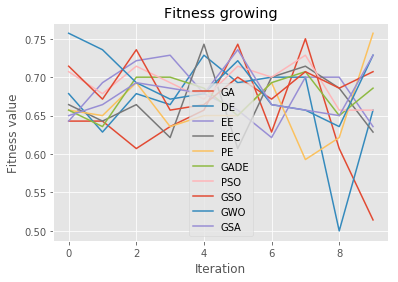

In [17]:
print(datacsv.mean(axis = 0))
print(datacsv.std())

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(testGA)), testGA, label="GA" )
plt.plot(np.arange(0, len(testDE)), testDE, label="DE")
plt.plot(np.arange(0, len(testEE)), testEE, label="EE" )
plt.plot(np.arange(0, len(testEEC)), testEEC, label="EEC")
plt.plot(np.arange(0, len(testPE)), testPE, label="PE" )
plt.plot(np.arange(0, len(testGADE)), testGADE, label="GADE")
plt.plot(np.arange(0, len(testPSO)), testPSO, label="PSO" )
plt.plot(np.arange(0, len(testGSO)), testGSO, label="GSO")
plt.plot(np.arange(0, len(testGWO)), testGWO, label = 'GWO')
plt.plot(np.arange(0, len(testGSA)), testGSA, label = 'GSA')
plt.title("Fitness growing")
plt.xlabel("Iteration")
plt.ylabel("Fitness value")
plt.legend()
plt.show()

# Kfold part DONT USE

In [18]:

k = KFold(n_splits=10)


################## INICIO KFOLD MLP SOZINHA #######################

scoresfinalMLP = []
modelMLP = Sequential()
modelMLP.add(Dense(6, input_dim = 50, activation="relu"))
modelMLP.add(Dense(1, activation="sigmoid"))    
modelMLP.compile( loss='binary_crossentropy', optimizer="adam", 
              metrics=['accuracy'])


#model3 = Sequential()
#model3.add(Dense(6, input_dim = 50, activation="relu"))
#model3.add(Dense(1, activation="sigmoid"))    
#model3.compile( loss='binary_crossentropy', optimizer="adam", 
#              metrics=['accuracy'])
#model3.load_weights("modelDE.h5")

#model3.fit(df_train_nolabels, df_train_labels, epochs=20, batch_size=256, verbose = False)
#retorno = model3.evaluate(df_validation_nolabels,df_validation_labels, verbose = False)
#retorno2 = model3.evaluate(df_test_nolabels,df_test_labels,verbose = False)
#print("look")
#print(retorno[1])
#print(retorno2[1])
#print()


timeinicialMLP = time.time()
for x in range(10):
  print("tam")
  for train_index, test_index in k.split(mlpdataX): 
    aux = []
    X_train, X_test = mlpdataX[train_index], mlpdataX[test_index]
    y_train, y_test = mlpdataY[train_index], mlpdataY[test_index]
    
    modelMLP.fit(X_train, y_train, epochs=20, batch_size=256, verbose = False)
    retorno = modelMLP.evaluate(X_test,y_test, verbose = False)
    aux.append(retorno[1])    
      
    mlpdataX,mlpdataY = shuffle(mlpdataX, mlpdataY, random_state=0)

  scoresfinalMLP.append(np.mean(aux))
timefinalMLP = time.time()
timetotalMLP = timefinalMLP - timeinicialMLP

    
    
################ FIM MLP SOZINHA ################################

############## KFOLD GA ##############################

kfoldscoresGA = []
modelGA = loadmodelGA()


for xGA in range(10):
  for train_index,test_index in k.split(mlpdataX):
    aux = []
    X_train, X_test = mlpdataX[train_index], mlpdataX[test_index]
    y_train, y_test = mlpdataY[train_index], mlpdataY[test_index]
    
    modelGA.fit(X_train,y_train,epochs=20,batch_size = 256,verbose = False)
    retorno = modelGA.evaluate(X_test,y_test,verbose = False)
    aux.append(retorno[1])
    
    mlpdataX,mlpdataY = shuffle(mlpdataX, mlpdataY, random_state=0)
    
  kfoldscoresGA.append(np.mean(aux))
  
    

############### FIM KFOLD GA ##################################

###################### KFOLD DE ##############################

kfoldscoresDE = []
modelDE = loadmodelDE()


for xDE in range(10):
  for train_index,test_index in k.split(mlpdataX):
    aux = []
    X_train, X_test = mlpdataX[train_index], mlpdataX[test_index]
    y_train, y_test = mlpdataY[train_index], mlpdataY[test_index]
    
    modelDE.fit(X_train,y_train,epochs=20,batch_size = 256,verbose = False)
    retorno = modelDE.evaluate(X_test,y_test,verbose = False)
    aux.append(retorno[1])
    
    mlpdataX,mlpdataY = shuffle(mlpdataX, mlpdataY, random_state=0)

  kfoldscoresDE.append(np.mean(aux))
  
                                
                               
################# FIM KFOLD DE ################################

################### KFOLD EE #################################
                                
kfoldscoresEE = [] 
modelEE = loadmodelEE()                              

for xEE in range(10):
  for train_index,test_index in k.split(mlpdataX):
    aux = []
    X_train, X_test = mlpdataX[train_index], mlpdataX[test_index]
    y_train, y_test = mlpdataY[train_index], mlpdataY[test_index]
    
    modelEE.fit(X_train,y_train,epochs=20,batch_size = 256,verbose = False)
    retorno = modelEE.evaluate(X_test,y_test,verbose = False)
    aux.append(retorno[1])
    
    mlpdataX,mlpdataY = shuffle(mlpdataX, mlpdataY, random_state=0)
  
  kfoldscoresEE.append(np.mean(aux))                                

################### FIM KFOLD EE ############################
                                
###################  KFOLD EEC ############################
kfoldscoresEEC = []
modelEEC = loadmodelEEC()
                                
for xEEC in range(10):
  for train_index,test_index in k.split(mlpdataX):
    aux = []
    X_train, X_test = mlpdataX[train_index], mlpdataX[test_index]
    y_train, y_test = mlpdataY[train_index], mlpdataY[test_index]
    
    modelEEC.fit(X_train,y_train,epochs=20,batch_size = 256,verbose = False)
    retorno = modelEEC.evaluate(X_test,y_test,verbose = False)
    aux.append(retorno[1])
    
    mlpdataX,mlpdataY = shuffle(mlpdataX, mlpdataY, random_state=0)
  
  kfoldscoresEEC.append(np.mean(aux))    
                                
################### FIM KFOLD EEC ############################                                
                                
#################### KFOLD PE ####################
                                
kfoldscoresPE = []
modelPE = loadmodelPE()
                                
for xPE in range(10):
  for train_index,test_index in k.split(mlpdataX):
    aux = []
    X_train, X_test = mlpdataX[train_index], mlpdataX[test_index]
    y_train, y_test = mlpdataY[train_index], mlpdataY[test_index]
    
    modelPE.fit(X_train,y_train,epochs=20,batch_size = 256,verbose = False)
    retorno = modelPE.evaluate(X_test,y_test,verbose = False)
    aux.append(retorno[1])
    
    mlpdataX,mlpdataY = shuffle(mlpdataX, mlpdataY, random_state=0)
  
  kfoldscoresPE.append(np.mean(aux))   
                                
##################### FIM KFOLD PE ########################
######################## KFOLD GA DE####################                               
kfoldscoresGADE = []
modelGADE = loadmodelGADE()

for xPE in range(10):
  for train_index,test_index in k.split(mlpdataX):
    aux = []
    X_train, X_test = mlpdataX[train_index], mlpdataX[test_index]
    y_train, y_test = mlpdataY[train_index], mlpdataY[test_index]
    
    modelGADE.fit(X_train,y_train,epochs=20,batch_size = 256,verbose = False)
    retorno = modelGADE.evaluate(X_test,y_test,verbose = False)
    aux.append(retorno[1])
    
    mlpdataX,mlpdataY = shuffle(mlpdataX, mlpdataY, random_state=0)
  
  kfoldscoresGADE.append(np.mean(aux))  

tam


NameError: ignored

# OLD FITNESS NO KFOLD ---DONT USE--

In [0]:
graphGA = []
graphDE = []
graphEE = []
graphEEC = []
graphPE = []
graphGADE = []
graphPSO = []
graphGSO = []



def fitnessGA(chromossome):
  

  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))

  hist = model.fit(df_train_nolabels, df_train_labels, epochs=50, batch_size=256, verbose = False)
  retorno = model.evaluate(df_validation_nolabels,df_validation_labels, verbose = False)
  
  if len(arrayfitnessGA) == 0:
    graphGA.append(retorno[1])
    model_json = model.to_json()
    with open("modelGA.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelGA.h5")
  

  atual = retorno[1]
  
  if len(arrayfitnessGA) > 1:
    if atual >= arrayfitnessGA[np.argmax(arrayfitnessGA)]:
      graphGA.append(atual)
    else:
      graphGA.append(arrayfitnessGA[np.argmax(arrayfitnessGA)])
  
  if len(arrayfitnessGA) > 1:
    if atual > arrayfitnessGA[np.argmax(arrayfitnessGA)]:
      model_json = model.to_json()
      with open("modelGA.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelGA.h5")
  
  arrayfitnessGA.append(retorno[1])
  return retorno[1]


def fitnessDE(chromossome):
  

  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))

  hist = model.fit(df_train_nolabels, df_train_labels, epochs=50, batch_size=256, verbose = False)
  retorno = model.evaluate(df_validation_nolabels,df_validation_labels, verbose = False)
  
  if len(arrayfitnessDE) == 0:
    graphDE.append(retorno[1])
    model_json = model.to_json()
    with open("modelDE.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelDE.h5")
  
  atual = retorno[1]
  
  if len(arrayfitnessDE) > 1:
    if atual >= arrayfitnessDE[np.argmax(arrayfitnessDE)]:
      graphDE.append(atual)
    else:
      graphDE.append(arrayfitnessDE[np.argmax(arrayfitnessDE)])  
  
  if len(arrayfitnessDE) > 1:
    if atual > arrayfitnessDE[np.argmax(arrayfitnessDE)]:
      model_json = model.to_json()
      with open("modelDE.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelDE.h5")
      
  arrayfitnessDE.append(retorno[1])
  return retorno[1]

def fitnessEE(chromossome):
  
  
  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))

  hist = model.fit(df_train_nolabels, df_train_labels, epochs=50, batch_size=256, verbose = False)
  retorno = model.evaluate(df_validation_nolabels,df_validation_labels, verbose = False)
  
  if len(arrayfitnessEE) == 0:
    graphEE.append(retorno[1])
    model_json = model.to_json()
    with open("modelEE.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelEE.h5")
  
  atual = retorno[1]
  
  if len(arrayfitnessEE) > 1:
    if atual >= arrayfitnessEE[np.argmax(arrayfitnessEE)]:
      graphEE.append(atual)
    else:
      graphEE.append(arrayfitnessEE[np.argmax(arrayfitnessEE)])
      
  if len(arrayfitnessEE) > 1:
    if atual > arrayfitnessEE[np.argmax(arrayfitnessEE)]:
      model_json = model.to_json()
      with open("modelEE.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelEE.h5")
      
  arrayfitnessEE.append(retorno[1])
  return retorno[1]

def fitnessEEC(chromossome):
  
  
  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))

  hist = model.fit(df_train_nolabels, df_train_labels, epochs=50, batch_size=256, verbose = False)
  retorno = model.evaluate(df_validation_nolabels,df_validation_labels, verbose = False)
  
  if len(arrayfitnessEEC) == 0:
    graphEEC.append(retorno[1])
    model_json = model.to_json()
    with open("modelEEC.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelEEC.h5")
  
  atual = retorno[1]
  
  if len(arrayfitnessEEC) > 1:
    if atual >= arrayfitnessEEC[np.argmax(arrayfitnessEEC)]:
      graphEEC.append(atual)
    else:
      graphEEC.append(arrayfitnessEEC[np.argmax(arrayfitnessEEC)])
    
  if len(arrayfitnessEEC) > 1:
    if atual > arrayfitnessEEC[np.argmax(arrayfitnessEEC)]:
      model_json = model.to_json()
      with open("modelEEC.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelEEC.h5")
      
  arrayfitnessEEC.append(retorno[1])  
  return retorno[1]

def fitnessPE(chromossome):
  

  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))

  hist = model.fit(df_train_nolabels, df_train_labels, epochs=50, batch_size=256, verbose = False)
  retorno = model.evaluate(df_validation_nolabels,df_validation_labels, verbose = False)
  
  
  if len(arrayfitnessPE) == 0:
    graphPE.append(retorno[1])
    model_json = model.to_json()
    with open("modelPE.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelPE.h5")
  
  atual = retorno[1]
  
  if len(arrayfitnessPE) > 1:
    if atual >= arrayfitnessPE[np.argmax(arrayfitnessPE)]:
      graphPE.append(atual)
    else:
      graphPE.append(arrayfitnessPE[np.argmax(arrayfitnessPE)])  
  
  if len(arrayfitnessPE) > 1:
    if atual > arrayfitnessPE[np.argmax(arrayfitnessPE)]:
      model_json = model.to_json()
      with open("modelPE.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelPE.h5")
      
  arrayfitnessPE.append(retorno[1])
  return retorno[1]



def fitnessGADE(chromossome):
  

  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))

  hist = model.fit(df_train_nolabels, df_train_labels, epochs=50, batch_size=256, verbose = False)
  retorno = model.evaluate(df_validation_nolabels,df_validation_labels, verbose = False)
  
  if len(arrayfitnessGADE) == 0:
    graphGADE.append(retorno[1])
    model_json = model.to_json()
    with open("modelGADE.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelGADE.h5")

  atual = retorno[1]
  
  if len(arrayfitnessGADE) > 1:
    if atual >= arrayfitnessGADE[np.argmax(arrayfitnessGADE)]:
      graphGADE.append(atual)
    else:
      graphGADE.append(arrayfitnessGADE[np.argmax(arrayfitnessGADE)])
  
  if len(arrayfitnessGADE) > 1:
    if atual > arrayfitnessGADE[np.argmax(arrayfitnessGADE)]:
      model_json = model.to_json()
      with open("modelGADE.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelGADE.h5")
  
  arrayfitnessGADE.append(retorno[1])
  return retorno[1]


def fitnessPSO(chromossome):
  

  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))

  hist = model.fit(df_train_nolabels, df_train_labels, epochs=50, batch_size=256, verbose = False)
  retorno = model.evaluate(df_validation_nolabels,df_validation_labels, verbose = False)
  
  if len(arrayfitnessPSO) == 0:
    graphPSO.append(retorno[1])
    model_json = model.to_json()
    with open("modelPSO.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelPSO.h5")

  atual = retorno[1]
  
  if len(arrayfitnessPSO) > 1:
    if atual >= arrayfitnessPSO[np.argmax(arrayfitnessPSO)]:
      graphPSO.append(atual)
    else:
      graphPSO.append(arrayfitnessPSO[np.argmax(arrayfitnessPSO)])
  
  if len(arrayfitnessPSO) > 1:
    if atual > arrayfitnessPSO[np.argmax(arrayfitnessPSO)]:
      model_json = model.to_json()
      with open("modelPSO.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelPSO.h5")
  
  arrayfitnessPSO.append(retorno[1])
  return retorno[1]


def fitnessGSO(chromossome):
  

  w1 = np.split(np.array(chromossome[0:len(chromossome)-6]), 50)
  w2 = np.reshape(chromossome[len(chromossome)-7:len(chromossome)-1], (6, 1))
  
  model.get_layer('dense1').set_weights((np.array(w1), np.zeros(6)))
  model.get_layer('dense2').set_weights((np.array(w2), np.zeros(1)))

  hist = model.fit(df_train_nolabels, df_train_labels, epochs=50, batch_size=256, verbose = False)
  retorno = model.evaluate(df_validation_nolabels,df_validation_labels, verbose = False)
  
  if len(arrayfitnessGSO) == 0:
    graphGSO.append(retorno[1])
    model_json = model.to_json()
    with open("modelGSO.json", "w") as json_file:
      json_file.write(model_json)
    model.save_weights("modelGSO.h5")

  atual = retorno[1]
  
  if len(arrayfitnessGSO) > 1:
    if atual >= arrayfitnessGSO[np.argmax(arrayfitnessGSO)]:
      graphGSO.append(atual)
    else:
      graphGSO.append(arrayfitnessGSO[np.argmax(arrayfitnessGSO)])
  
  if len(arrayfitnessGSO) > 1:
    if atual > arrayfitnessGSO[np.argmax(arrayfitnessGSO)]:
      model_json = model.to_json()
      with open("modelGSO.json", "w") as json_file:
        json_file.write(model_json)
      model.save_weights("modelGSO.h5")
  
  arrayfitnessGSO.append(retorno[1])
  return retorno[1]



from SwarmPackagePy.intelligence import sw


class gsa(sw):

    def __init__(self, n, function, lb, ub, dimension, iteration,Xtrain,ytrain,Xval,yval, init=None, G0=3):

        super(gsa, self).__init__()

        if init is None:
            self.__agents = np.random.uniform(lb, ub, (n, dimension))
        else:
            self.__agents = np.array(init)
        
        self._points(self.__agents)

        Pbest = self.__agents[np.array([function(x,Xtrain,ytrain,Xval,yval)
                                        for x in self.__agents]).argmax()]
        Gbest = Pbest

        velocity = np.array([[0 for k in range(dimension)] for i in range(n)])

        for t in range(iteration):

            csi = np.random.random((n, dimension))
            eps = np.random.random((1, n))[0]

            fitness = np.array([function(x,Xtrain,ytrain,Xval,yval) for x in self.__agents])

            m = np.array([(function(x,Xtrain,ytrain,Xval,yval) - max(fitness)) /
                       (min(fitness) - max(fitness)) for x in self.__agents])
            M = np.array([i / sum(m) for i in m])

            G = G0 / exp(0.01 * t)
            a = np.array([sum([eps[j] * G * M[j] *
                            (self.__agents[j] - self.__agents[i]) / (
                np.linalg.norm(self.__agents[i] - self.__agents[j]) + 0.001)
                            for j in range(n)]) for i in range(n)])

            velocity = csi * velocity + np.array([a[i] for i in range(n)])
            self.__agents += velocity
            self.__agents = np.clip(self.__agents, lb, ub)
            self._points(self.__agents)

            Pbest = self.__agents[
                np.array([function(x,Xtrain,ytrain,Xval,yval) for x in self.__agents]).argmax()]
            if function(Pbest,Xtrain,ytrain,Xval,yval) > function(Gbest,Xtrain,ytrain,Xval,yval):
                Gbest = Pbest

        self._set_Gbest(Gbest)
        
        
from SwarmPackagePy.intelligence import sw

class pso(sw):

    def __init__(self, n, function, lb, ub, dimension, iteration,Xtrain,ytrain,Xval,yval, init=None, w=0.5, c1=1,
                 c2=1):

        super(pso, self).__init__()
        self.scores = []

        if init is None:
            self.__agents = np.random.uniform(lb, ub, (n, dimension))
        else:
            self.__agents = np.array(init)

        velocity = np.zeros((n, dimension))
        self._points(self.__agents)
        

        Pbest = self.__agents[np.array([function(x,Xtrain,ytrain,Xval,yval)
                                        for x in self.__agents]).argmax()]
        Gbest = Pbest
        

        for t in range(iteration):

            r1 = np.random.random((n, dimension))
            r2 = np.random.random((n, dimension))
            velocity = w * velocity + c1 * r1 * (
                Pbest - self.__agents) + c2 * r2 * (
                Gbest - self.__agents)
            self.__agents += velocity
            self.__agents = np.clip(self.__agents, lb, ub)
            self._points(self.__agents)

            Pbest = self.__agents[
                np.array([function(x,Xtrain,ytrain,Xval,yval) for x in self.__agents]).argmax()]
            
            self.scores.append(function(Pbest,Xtrain,ytrain,Xval,yval))
            if function(Pbest,Xtrain,ytrain,Xval,yval) > function(Gbest,Xtrain,ytrain,Xval,yval):
                Gbest = Pbest


        self._set_Gbest(Gbest)
               
    
    def get_Score(self):     
      return self.scores